### denoising autoencoder test
this is the test of the deenoising autoencoder that was suggested by copilot.

the data is the simple case used in our earier blog.  it consists of the radio signal with simple cosine noise.
the data had to be reshaped to fit the autoencoder correctly  [*,1,496]  rather than the [*,1,500]

In [1]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import random_split
from torch.utils.data import TensorDataset
from torch.utils.data import Subset
from torch.utils.data import ConcatDataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
import time
import datetime
import math


In [2]:
torch.cuda.is_available()

True

In [3]:

class ConvDenoisingAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ConvDenoisingAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 16, 3, stride=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool1d(2, stride=2),
            nn.Conv1d(16, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.MaxPool1d(2, stride=1)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(8, 16, 3, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose1d(16, 8, 5, stride=3, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose1d(8, 1, 2, stride=2, padding=1),
            nn.ReLU(True)
        )
    def forward(self, x):
        x = self.encoder(x)
        #print(x.shape)
        x = self.decoder(x)
        return x
        


In [4]:
net = ConvDenoisingAutoencoder(0,0,0)

In [5]:
x = np.zeros(2*496)
x = x.astype('float32')
x = torch.from_numpy(x)
x = x.reshape([2,1,496])
x.shape

torch.Size([2, 1, 496])

In [6]:
y = net(x)
y.shape

torch.Size([2, 1, 496])

In [7]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
# to select the noise model to use, set the following variable.
#it is either uniform, cosine or original
NOISE = 'uniform'
  
# defining the Dataset class
class data_set(Dataset):
    def __init__(self, nums):
        numbers = nums
        self.data = numbers
  
    def __len__(self):
        return len(self.data)
  
    def __getitem__(self, index):
        return self.data[index]

In [8]:
def replace_data2(x):    
    z = np.zeros(x.shape)
    d = -0.5
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            q = 0.25*(np.cos(j*np.pi/10)-0.5)+x[i,j]
            if q > 0.62+d:
                q  =  0.62+d
            if q < 0.2+d:
                q = 0.2+d
            z[i,j]= q+.1
    return z

In [9]:
import os
import gdown
url = "https://drive.google.com/u/0/uc?export=download&confirm=HgGH&id=1R-qfxO1jVh88TC9Gnm9JGMomSRg0Zpkx"
output = 'radio_data.npz'

if os.path.exists(output) == False:
    gdown.download(url, output, quiet=True)

f = np.load(output)
n_train = 40000

x_train0 = f["traces"]  # measured traces (signal + colored noise)
signals0 = f["signals"]  # signal part (only available for cosmic-ray events)

x_train0 = replace_data2(signals0)

labels0 = (signals0.std(axis=-1) != 0).astype(float)  # define training label (1=cosmic event, 0=noise)
x_train = x_train0[:n_train]
x_test = x_train0[n_train:]

In [10]:
x_train0 = f["traces"]  # measured traces (signal + colored noise)
signals0 = f["signals"]  # signal part (only available for cosmic-ray events)

print(x_train0.shape)
sigs = np.zeros([50000,496])
tran = np.zeros([50000,496])
for i in range(50000):
    for j in range(496):
        tran[i,j] = x_train0[i,j]
        sigs[i,j] = signals0[i,j]
print(tran.shape)

(50000, 500)
(50000, 496)


In [11]:
signals0x =  sigs
x_train0x = tran
x_train0x = replace_data2(signals0x)
print(signals0x.shape)
labels0x = (signals0x.std(axis=-1) != 0).astype(float)  # define training label (1=cosmic event, 0=noise)
x_trainx = x_train0x[:n_train]
x_testx = x_train0x[n_train:]
print(x_train0x.shape)

(50000, 496)
(50000, 496)


In [12]:
sigs_train  = signals0x[:n_train]
sigs_test = signals0x[n_train:]
sigma = x_trainx.std()
sigma = 1
x_train = x_trainx/sigma+0.5
x_test = x_testx/sigma+0.5
sigs_train= sigs_train/sigma+0.5
sigs_test  = sigs_test/sigma+0.5

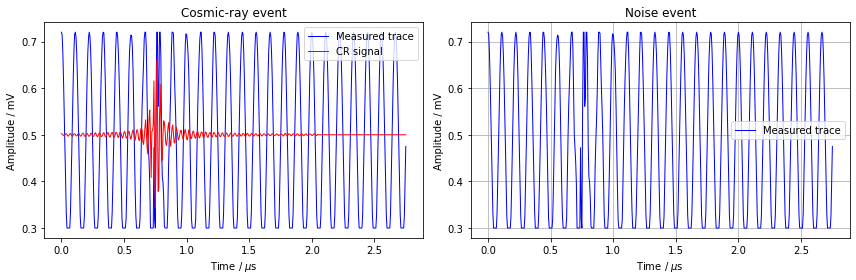

In [13]:
idx =12
fs = 180e6  # Sampling frequency of antenna setup 180 MHz
t = np.arange(496) / fs * 1e6

plt.figure(1, (12, 4))
plt.subplot(1, 2, 1)
#plt.plot(t, np.real(f["traces"][labels.astype(bool)][idx]), linewidth = 1, color="b", label="Measured trace")
plt.plot(t, np.real(x_train[idx]), linewidth = 1, color="b", label="Measured trace")
plt.plot(t, np.real(0.8*(sigs_train[idx]-0.5)+0.5), linewidth = 1, color="r", label="CR signal")
plt.ylabel('Amplitude / mV')
plt.xlabel('Time / $\mu \mathrm{s}$')
plt.legend()
plt.title("Cosmic-ray event")
plt.subplot(1, 2, 2)

plt.plot(t, np.real(x_train[idx]), linewidth = 1, color="b", label="Measured trace")
#plt.plot(t, np.real(x_train[~y_train.astype(bool)][idx2]), linewidth = 1, color="b", label="Measured trace")
plt.ylabel('Amplitude / mV')
plt.xlabel('Time / $\mu \mathrm{s}$')
plt.legend()
plt.title("Noise event")

plt.grid(True)
plt.tight_layout()

In [14]:
biglist = []
for i in range(n_train):
    item = [torch.tensor(x_train[i]).unsqueeze(0).float()]
    item.append(torch.tensor(sigs_train[i]).unsqueeze(0).float())
    biglist.append(item)

In [15]:
dataset = data_set(biglist)
batch_size = 20

  
biglist1 = []
for i in range(len(x_test)):
    item = [torch.tensor(x_test[i]).unsqueeze(0).float()]
    item.append(torch.tensor(sigs_test[i]).unsqueeze(0).float())
    biglist1.append(item)
    
testset = data_set(biglist1)
traindat = data_set(biglist)

In [16]:
# Create training and test dataloaders
num_workers = 0
# how many samples per batch to load

testset = data_set(biglist1)
traindat = data_set(biglist)
test_loader = DataLoader(testset, batch_size=1, shuffle=True)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(traindat, batch_size=batch_size, num_workers=num_workers)


In [17]:
for data in train_loader:        
        images, signal = data
        print("images", images.shape)
        print('signals', signal.shape)
        break

images torch.Size([20, 1, 496])
signals torch.Size([20, 1, 496])


In [18]:
y = net(images)
y.shape

torch.Size([20, 1, 496])

In [19]:
criterion = nn.MSELoss()
model = net
# specify loss function
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = torch.optim.Adam(model.parameters(), lr=0.0015)
model = model.to(device)

In [20]:
device

device(type='cuda')

In [21]:
# number of epochs to train the model
n_epochs = 20

# for adding noise to images
noise_factor=0.5

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data in train_loader:
        
        images, signal = data
        #print("images", images.shape)
        #print('signals', signal.shape)
        
        # Clip the images to be between 0 and 1
        #noisy_imgs = np.clip(noisy_imgs, 0., 1.)
                
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        ## forward pass: compute predicted outputs by passing *noisy* images to the model
        outputs = model(images.to(device))
        # calculate the loss
        # the "target" is still the original, not-noisy images
        loss = criterion(outputs, signal.to(device))
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)
            
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))

Epoch: 1 	Training Loss: 0.015752
Epoch: 2 	Training Loss: 0.004372
Epoch: 3 	Training Loss: 0.003935
Epoch: 4 	Training Loss: 0.003570
Epoch: 5 	Training Loss: 0.003295
Epoch: 6 	Training Loss: 0.003103
Epoch: 7 	Training Loss: 0.002976
Epoch: 8 	Training Loss: 0.002858
Epoch: 9 	Training Loss: 0.002762
Epoch: 10 	Training Loss: 0.002679
Epoch: 11 	Training Loss: 0.002625
Epoch: 12 	Training Loss: 0.002575
Epoch: 13 	Training Loss: 0.002535
Epoch: 14 	Training Loss: 0.002494
Epoch: 15 	Training Loss: 0.002460
Epoch: 16 	Training Loss: 0.002423
Epoch: 17 	Training Loss: 0.002396
Epoch: 18 	Training Loss: 0.002363
Epoch: 19 	Training Loss: 0.002338
Epoch: 20 	Training Loss: 0.002315


In [22]:
dataiter = iter(test_loader)

In [28]:
fs = 180e6  # Sampling frequency of antenna setup 180 MHz
t = np.arange(496) / fs * 1e6

def shownext():
    x,y = dataiter.next()
    #look for a case where the ray is there
    while y[0].std(axis=-1) == 0:
        x, y = dataiter.next()
    z = model(x.to(device))
    z = z.cpu()
    #return x, y,  z.detach().numpy()
    plt.figure(1, (12, 4))
    plt.subplot(1,2, 1)
    #plt.plot(t, np.real(f["traces"][labels.astype(bool)][idx]), linewidth = 1, color="b", label="Measured trace")
    plt.plot(t, np.real(x[0,0,:].detach().numpy()), linewidth = 1, color="b", label="Measured trace")
    plt.plot(t, np.real(0.7*y[0,0,:].detach().numpy()+0.15), linewidth = 1, color="r", label="CR signal")
    plt.ylabel('Amplitude / mV')
    plt.xlabel('Time / $\mu \mathrm{s}$')
    plt.legend()
    plt.title("Cosmic-ray event")
    plt.subplot(1, 2, 2)

    #plt.plot(t, np.real(0.7*y[0,0,:]+0.15), linewidth = 1, color="r", label="CR signal")
    plt.plot(t, np.real(z[0,0,:].detach().numpy()), linewidth = 1, color="b", label="noise removed")
    plt.axis([0, 3.0, .2, .76])
    #plt.plot(t, np.real(x_train[~y_train.astype(bool)][idx2]), linewidth = 1, color="b", label="Measured trace")
    plt.ylabel('Amplitude / mV')
    plt.xlabel('Time / $\mu \mathrm{s}$')
    plt.legend()
    plt.title("recovered event")
    plt.grid(True)
    plt.tight_layout()
    return x, y,  z.detach().numpy()

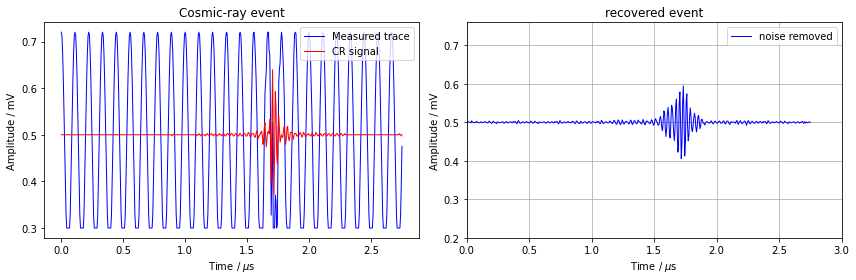

In [29]:

x, y, z = shownext()

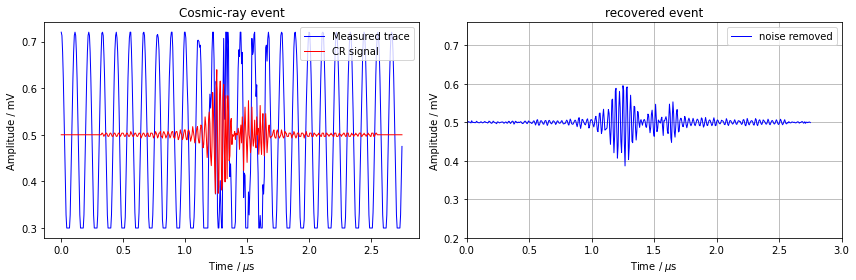

In [30]:
x, y, z = shownext()

In [31]:
x,y = dataiter.next()

In [32]:
x.shapetorch.Size([20, 1, 496])

torch.Size([20, 1, 496])

In [33]:
y.shape

torch.Size([20, 1, 496])

In [70]:
x0 = x[0,:,0:496]

In [71]:
x0.shape

torch.Size([1, 496])

In [72]:
x0 = x0.reshape(1,1,496)

In [73]:
x0.shape

torch.Size([1, 1, 496])

In [74]:
z = model(x0.to(device))

In [75]:
z.shape

torch.Size([1, 1, 496])

In [43]:
496/16

31.0